In [2]:
import numpy as np
from utils import *
from matplotlib.pyplot import plot
import torch
import torch.nn.functional as F
from mpl_toolkits.mplot3d import Axes3D

### Mesh Points

In [3]:
nx = 50 
nt = 500*2
dx = 0.1
dt = 0.01/2
D = 0.1 #diffusion coeff
sigma = 0.05

In [3]:
def getMeshPoints(nx,nt,dx,dt):
    x = np.linspace(0,dx*nx,nx)
    t = np.linspace(0,dt*nt,nt)
    return x,t

In [4]:
x,t = getMeshPoints(nx,nt,dx,dt)

In [5]:
x

array([0.        , 0.10204082, 0.20408163, 0.30612245, 0.40816327,
       0.51020408, 0.6122449 , 0.71428571, 0.81632653, 0.91836735,
       1.02040816, 1.12244898, 1.2244898 , 1.32653061, 1.42857143,
       1.53061224, 1.63265306, 1.73469388, 1.83673469, 1.93877551,
       2.04081633, 2.14285714, 2.24489796, 2.34693878, 2.44897959,
       2.55102041, 2.65306122, 2.75510204, 2.85714286, 2.95918367,
       3.06122449, 3.16326531, 3.26530612, 3.36734694, 3.46938776,
       3.57142857, 3.67346939, 3.7755102 , 3.87755102, 3.97959184,
       4.08163265, 4.18367347, 4.28571429, 4.3877551 , 4.48979592,
       4.59183673, 4.69387755, 4.79591837, 4.89795918, 5.        ])

### Initial and Boundary Condtions

In [157]:
def I(x,L=1.,sigma=0.05):
    """Gaussian profile as initial condition."""
    return np.exp(-0.5*((x-L/2.0)**2)/sigma**2)

In [538]:
def I2(x, L):
    return list(map(int,(x>L/4)*(x<3*L/4)))

In [158]:
u0 = I(x,dx*nx,1)

In [634]:
u0 = (u0 - min(u0))/(max(u0)-min(u0))

## Generating In Batches

Sigma would be uniform distributions between 1 and 2 and the the coeff would be uniform between 0 and 1

In [1]:
class DataModel:
    def __init__(self,data_name,Nt,Nx,dt,dx,**kw):
        self.data_name = data_name
        self.Nt = Nt
        self.Nx = Nx
        self.dt = dt
        self.dx = dx
    
    @property
    def Lx(self):
        return self.dx*self.Nx
    
    @property
    def Lt(self):
        return self.dt*self.Nt
    
    def data(self):
        '''returns data
        '''
        raise NotImplementedError
        
    def _getMeshPoints(self):
        x = np.linspace(0,self.Lx,self.Nx)
        t = np.linspace(0,self.Lt,self.Nt)
        return x,t

            
    def visualize(self):
        fig = plt.figure(figsize=(8,8))
        ax = fig.add_subplot(111, projection='3d')
        X,T = np.meshgrid(self.x,self.t)        
        surf = ax.plot_surface(T, X, self.u_viz)
        plt.xlabel("Time")
        plt.ylabel("X")
        plt.show()
        

In [6]:
class TimeStepper:
    def __init__(self,dx,dt,time_scheme='rk4',acc_order=2,**kw):
        self.dx = dx
        self.dt = dt
        self.acc_order = acc_order
        self.time_scheme = time_scheme
    def _step_(self, ut):
        dt = self.dt
        if self.time_scheme == 'rk4': # classical 4-stage 4th-order Runge–Kutta method
            K1 = self.RightHandItems(ut)
            K2 = self.RightHandItems(ut+dt/2*K1)
            K3 = self.RightHandItems(ut+dt/2*K2)
            K4 = self.RightHandItems(ut+dt*K3)
            rhi = dt/6*(K1+2*K2+2*K3+K4)
        elif self.time_scheme == 'rk2': # 2-stage 2nd-order Runge–Kutta method
            K1 = self.RightHandItems(ut)
            K2 = self.RightHandItems(ut+dt*K1)
            rhi = dt/2*(K1+K2)
        else: # forward Euler
            rhi = dt*self.RightHandItems(ut)
        return rhi
    
    def step(self, ut):
        ut_1 = ut+self._step_(ut)
        return ut_1

    
    #takes the function at time t 
    def RightHandItems(self, ut):
            raise NotImplementedError


In [7]:

    
class DiffusionData(DataModel,TimeStepper):
    def __init__(self,data_name,Nt,Nx,dt,dx,diff_coeff,batch_size,acc_order=2,time_scheme='rk4'):
        '''
            currently only batch size of 1 is supported
        '''
        Nx = 2*Nx
        super(DiffusionData,self).__init__(data_name=data_name,Nt=Nt, Nx=Nx, dt=dt, dx=dx,time_scheme=time_scheme\
                                          ,acc_order=acc_order)
        self.time_scheme = time_scheme
        self.diff_coeff = diff_coeff
        self.acc_order = acc_order
        self.batch_size = batch_size
#         self.ts = TimeStepper(self.dx,self.dt,time_scheme=time_scheme)
        self._data = self._generateData()

    
    def _generateData(self):
        start = int(self.Nx/4)
        end = 3*int(self.Nx/4)
        self.x,self.t =  self._getMeshPoints()
        u0 = self._IGaussian() #batch_size x 1 x X_dim
        u0[...,0] = u0[...,-1] = 0
        u0 = (u0-u0.min(axis=-1)[:,np.newaxis,:])/((u0.max(axis=-1)-u0.min(axis=-1))[:,np.newaxis,:])
        u = []   
        ut = torch.from_numpy(u0)
        u.append(torch.from_numpy(u0[...,start:end]))
        for i in range(1,self.Nt):
            u_next = self.step(ut)
            #boundary condtion
            u_next[...,0] = 0
            u_next[...,-1] = 0
            ut = u_next
            u.append(u_next[...,start:end])

        return u
        
    def _IGaussian(self):
        sigma = 2*np.random.uniform(1,2,self.batch_size).reshape(-1,1)
        scale = 2*np.random.uniform(0,1,self.batch_size).reshape(-1,1)
        return (scale*np.exp(-0.5*((self.x-self.Lx/2.0)**2)/sigma**2)).reshape((self.batch_size,1,-1))
    
    def data(self,step_num):
        return self._data[:step_num]
    
    #takes the function at time t 
    def RightHandItems(self, ut):
            ## should calculate the rhs a*d2u/dx2
            F_c = self.diff_coeff/self.dx**2
            kernel = getKernelTorch(2,self.acc_order)
            ut_padded = padInputTorch(ut,2,self.acc_order)
            uxx_t = F.conv1d(ut_padded,kernel)
            return F_c*uxx_t

    

In [251]:
datamodel = DiffusionData("diffusion",nt,nx,dt,dx,D,batch_size=1)

In [256]:
datamodel._data[0]

tensor([[[0.5864, 0.6120, 0.6375, 0.6630, 0.6882, 0.7132, 0.7377, 0.7617,
          0.7851, 0.8077, 0.8296, 0.8505, 0.8704, 0.8892, 0.9068, 0.9231,
          0.9380, 0.9514, 0.9633, 0.9737, 0.9824, 0.9894, 0.9947, 0.9982,
          1.0000, 1.0000, 0.9982, 0.9947, 0.9894, 0.9824, 0.9737, 0.9633,
          0.9514, 0.9380, 0.9231, 0.9068, 0.8892, 0.8704, 0.8505, 0.8296,
          0.8077, 0.7851, 0.7617, 0.7377, 0.7132, 0.6882, 0.6630, 0.6375,
          0.6120, 0.5864]]], dtype=torch.float64)

In [240]:
class BurgersEqn(DataModel,TimeStepper):
    def __init__(self,data_name,Nt,Nx,dt,dx,viscosity,batch_size,acc_order=2,time_scheme='rk4'):
        '''
            currently only batch size of 1 is supported
        '''
        Nx = 2*Nx
        super(BurgersEqn,self).__init__(data_name=data_name,Nt=Nt, Nx=Nx, dt=dt, dx=dx,time_scheme=time_scheme\
                                          ,acc_order=acc_order)
        self.time_scheme = time_scheme
        self.viscosity = viscosity
        self.acc_order = acc_order
        self.batch_size = batch_size
        self._data = self._generateData()   
    
        
    def _generateData(self):
        start = int(self.Nx/4)
        end = 3*int(self.Nx/4)
        self.x,self.t =  self._getMeshPoints()
        u0 = self._IGaussian() #batch_size x 1 x X_dim
        u0[...,0] = u0[...,-1] = 0
        u0 = (u0-u0.min(axis=-1)[:,np.newaxis,:])/((u0.max(axis=-1)-u0.min(axis=-1))[:,np.newaxis,:])
        u = []   
        ut = torch.from_numpy(u0)
        u.append(torch.from_numpy(u0[...,start:end]))
        for i in range(1,self.Nt):
            u_next = self.step(ut)
            #boundary condtion
            u_next[...,0] = 0
            u_next[...,-1] = 0
            ut = u_next
            u.append(u_next[...,start:end])
        return u
        
    def _IGaussian(self):
        sigma = 2*np.random.uniform(1,2,self.batch_size).reshape(-1,1)
        scale = 2*np.random.uniform(0,1,self.batch_size).reshape(-1,1)
        return (scale*np.exp(-0.5*((self.x-self.Lx/2.0)**2)/sigma**2)).reshape((self.batch_size,1,-1))
    
    def data(self,step_num):
        return self._data[:step_num]
    
    #takes the function at time t 
    def RightHandItems(self, ut):
            ## should calculate the rhs a*d2u/dx2
            #1st order
            kernel_or1 = getKernelTorch(1,self.acc_order)
            ut_padded_or1 = padInputTorch(ut,1,self.acc_order)
            ux_t = F.conv1d(ut_padded_or1,kernel_or1)/self.dx     
            #2nd order 
            kernel_or2 = getKernelTorch(2,self.acc_order)
            ut_padded_or2 = padInputTorch(ut,2,self.acc_order)
            uxx_t = F.conv1d(ut_padded_or2,kernel_or2)/self.dx**2
            
            return self.viscosity*uxx_t - ut*ux_t


In [241]:
datamodel_burg = BurgersEqn("diffusion",nt,nx,dt,dx,batch_size=1,viscosity=0.1)

In [244]:
datamodel_burg._data[0]

tensor([[[0.4965, 0.5251, 0.5541, 0.5833, 0.6126, 0.6418, 0.6709, 0.6997,
          0.7280, 0.7557, 0.7827, 0.8087, 0.8336, 0.8572, 0.8795, 0.9003,
          0.9194, 0.9367, 0.9522, 0.9656, 0.9769, 0.9861, 0.9930, 0.9977,
          1.0000, 1.0000, 0.9977, 0.9930, 0.9861, 0.9769, 0.9656, 0.9522,
          0.9367, 0.9194, 0.9003, 0.8795, 0.8572, 0.8336, 0.8087, 0.7827,
          0.7557, 0.7280, 0.6997, 0.6709, 0.6418, 0.6126, 0.5833, 0.5541,
          0.5251, 0.4965]]], dtype=torch.float64)

## Initial condition using multiple waves

In [277]:
def _ITrigno(x,t,batch_size):
    w0 = 0
    c = np.random.uniform(-2,2,(batch_size,1))
    for k in range(-4,5):
        mew_k = np.random.normal(0,1,(batch_size,1))
        lambda_k = np.random.normal(0,1,(batch_size,1))
        w0 += mew_k*np.sin(k*x) + lambda_k*np.cos(k*x)
    
    I = (2*w0)/np.abs(w0).max(axis=-1)[:,np.newaxis]+c
    return I

In [278]:
x = np.linspace(0,dx*128,128)
t = np.linspace(0,dt*nt,nt)

In [281]:
inits = _ITrigno(x,t,1)

In [285]:
inits

array([[-0.93302947, -0.6609201 , -0.43068317, -0.27292221, -0.21042203,
        -0.25449968, -0.40277042, -0.63874798, -0.93344056, -1.24880935,
        -1.54267116, -1.77439518, -1.91060233, -1.93004942, -1.82697534,
        -1.61239063, -1.31307752, -0.96839206, -0.62527598, -0.33214647,
        -0.13249749, -0.05909205, -0.12954374, -0.34388993, -0.68447685,
        -1.11815165, -1.60043466, -2.08107533, -2.51021564, -2.84432044,
        -3.05109194, -3.11275476, -3.02734995, -2.80797199, -2.48017572,
        -2.07802777, -1.63944189, -1.2014992 , -0.79640685, -0.44860366,
        -0.17330663,  0.02345574,  0.1435169 ,  0.19433904,  0.18637579,
         0.13055751,  0.03635648, -0.08925734, -0.24185492, -0.41867598,
        -0.61712537, -0.83304541, -1.05921946, -1.28452145, -1.49400413,
        -1.67003693, -1.79439436, -1.85099573, -1.82884263, -1.7246218 ,
        -1.5444541 , -1.3043771 , -1.02933427, -0.75068042, -0.50246155,
        -0.3169483 , -0.22005608, -0.22734521, -0.3

In [27]:
class DiffusionDataTrign(DataModel,TimeStepper):
    def __init__(self,data_name,Nt,dt,dx,diff_coeff,batch_size,acc_order=2,time_scheme='rk4'):
        '''
            currently only batch size of 1 is supported
        '''
        Nx = 128
        super(DiffusionDataTrign,self).__init__(data_name=data_name,Nt=Nt, Nx=Nx, dt=dt, dx=dx,time_scheme=time_scheme\
                                          ,acc_order=acc_order)
        self.time_scheme = time_scheme
        self.diff_coeff = diff_coeff
        self.acc_order = acc_order
        self.batch_size = batch_size
#         self.ts = TimeStepper(self.dx,self.dt,time_scheme=time_scheme)
        self._data = self._generateData()

    
    def _generateData(self):
        start = 48
        end = 80
        self.x,self.t =  self._getMeshPoints()
        u0 = self._ITrigno() #batch_size x 1 x X_dim
        u0[...,0] = u0[...,-1] = 0
        u = []   
        u_whole = []
        ut = torch.from_numpy(u0)
        u_whole.append(torch.from_numpy(u0))
        u.append(torch.from_numpy(u0[...,start:end]))
        for i in range(1,self.Nt):
            u_next = self.step(ut)
            #boundary condtion
            u_next[...,0] = 0
            u_next[...,-1] = 0
            ut = u_next
            u.append(u_next[...,start:end])
            u_whole.append(u_next)
            
        self.u_all = u_whole
        return u
        
    def _IGaussian(self):
        sigma = 2*np.random.uniform(1,2,self.batch_size).reshape(-1,1)
        scale = 2*np.random.uniform(0,1,self.batch_size).reshape(-1,1)
        return (scale*np.exp(-0.5*((self.x-self.Lx/2.0)**2)/sigma**2)).reshape((self.batch_size,1,-1))
    
    
    def _ITrigno(self):
        batch_size = self.batch_size
        w0 = 0.0
        c = np.random.uniform(-2,2,(batch_size,1))
        for k in range(-4,5):
            mew_k = np.random.normal(0,1,(batch_size,1))
            lambda_k = np.random.normal(0,1,(batch_size,1))
            w0 += mew_k*np.sin(k*self.x) + lambda_k*np.cos(k*self.x)

        I = (2*w0)/np.abs(w0).max(axis=-1)[:,np.newaxis]+c
        return I[:,np.newaxis,:]
    
    def data(self,step_num):
        return self._data[:step_num]
    
    #takes the function at time t 
    def RightHandItems(self, ut):
            ## should calculate the rhs a*d2u/dx2
            F_c = self.diff_coeff/self.dx**2
            kernel = getKernelTorch(2,self.acc_order)
            ut_padded = padInputTorch(ut,2,self.acc_order)
            uxx_t = F.conv1d(ut_padded,kernel)
            return F_c*uxx_t
    
    def visualize(self,b,subset=True):
        #displays ith batch plot
        ##time x batch_size x 1 x x_dim 
        u = []
        disp_arr = self.u_all
        x = self.x
        if subset:
            disp_arr = self._data
            x = self.x[48:80]
            
        for i in range(len(self._data)):
            u.append(np.array(disp_arr[i][b]).reshape(-1))
        u = np.array(u)
        
        fig = plt.figure(figsize=(8,8))
        ax = fig.add_subplot(111, projection='3d')
        X,T = np.meshgrid(x,self.t)        
        surf = ax.plot_surface(T, X, u)
        plt.xlabel("Time")
        plt.ylabel("X")
        plt.show()
        
        return u

In [28]:
data_model = DiffusionDataTrign("diffusion",nt,dt,dx,D,batch_size=32)

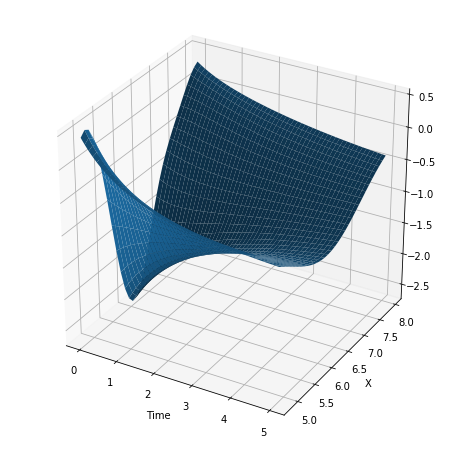

In [32]:
u = data_model.visualize(13,subset=True)

In [33]:
class BurgersEqnTrign(DataModel,TimeStepper):
    def __init__(self,data_name,Nt,dt,dx,viscosity,batch_size,acc_order=2,time_scheme='rk4'):
        '''
            currently only batch size of 1 is supported
        '''
        Nx = 128
        super(BurgersEqnTrign,self).__init__(data_name=data_name,Nt=Nt, Nx=Nx, dt=dt, dx=dx,time_scheme=time_scheme\
                                          ,acc_order=acc_order)
        self.time_scheme = time_scheme
        self.viscosity = viscosity
        self.acc_order = acc_order
        self.batch_size = batch_size
        self._data = self._generateData()   
    
        
    def _generateData(self):
        start = 48
        end = 80
        self.x,self.t =  self._getMeshPoints()
        u0 = self._ITrigno() #batch_size x 1 x X_dim
        u0[...,0] = u0[...,-1] = 0
        u = []   
        u_whole = []
        ut = torch.from_numpy(u0)
        u_whole.append(torch.from_numpy(u0))
        u.append(torch.from_numpy(u0[...,start:end]))
        for i in range(1,self.Nt):
            u_next = self.step(ut)
            #boundary condtion
            u_next[...,0] = 0
            u_next[...,-1] = 0
            ut = u_next
            u.append(u_next[...,start:end])
            u_whole.append(u_next)
            
        self.u_all = u_whole
        return u
        
    def _IGaussian(self):
        sigma = 2*np.random.uniform(1,2,self.batch_size).reshape(-1,1)
        scale = 2*np.random.uniform(0,1,self.batch_size).reshape(-1,1)
        return (scale*np.exp(-0.5*((self.x-self.Lx/2.0)**2)/sigma**2)).reshape((self.batch_size,1,-1))
    
    def _ITrigno(self):
        batch_size = self.batch_size
        w0 = 0.0
        c = np.random.uniform(-2,2,(batch_size,1))
        for k in range(-4,5):
            mew_k = np.random.normal(0,1,(batch_size,1))
            lambda_k = np.random.normal(0,1,(batch_size,1))
            w0 += mew_k*np.sin(k*self.x) + lambda_k*np.cos(k*self.x)

        I = (2*w0)/np.abs(w0).max(axis=-1)[:,np.newaxis]+c
        return I[:,np.newaxis,:]
    
    def data(self,step_num):
        return self._data[:step_num]
    
    #takes the function at time t 
    def RightHandItems(self, ut):
            ## should calculate the rhs a*d2u/dx2
            #1st order
            kernel_or1 = getKernelTorch(1,self.acc_order)
            ut_padded_or1 = padInputTorch(ut,1,self.acc_order)
            ux_t = F.conv1d(ut_padded_or1,kernel_or1)/self.dx     
            #2nd order 
            kernel_or2 = getKernelTorch(2,self.acc_order)
            ut_padded_or2 = padInputTorch(ut,2,self.acc_order)
            uxx_t = F.conv1d(ut_padded_or2,kernel_or2)/self.dx**2
            
            return self.viscosity*uxx_t - ut*ux_t

        
    def visualize(self,b,subset=True):
        #displays ith batch plot
        ##time x batch_size x 1 x x_dim 
        u = []
        disp_arr = self.u_all
        x = self.x
        if subset:
            disp_arr = self._data
            x = self.x[48:80]
            
        for i in range(len(self._data)):
            u.append(np.array(disp_arr[i][b]).reshape(-1))
        u = np.array(u)
        
        fig = plt.figure(figsize=(8,8))
        ax = fig.add_subplot(111, projection='3d')
        X,T = np.meshgrid(x,self.t)        
        surf = ax.plot_surface(T, X, u)
        plt.xlabel("Time")
        plt.ylabel("X")
        plt.show()
        
        return u

In [34]:
data_model_burgers = BurgersEqnTrign("burgers",nt,dt,dx,D,batch_size=2)

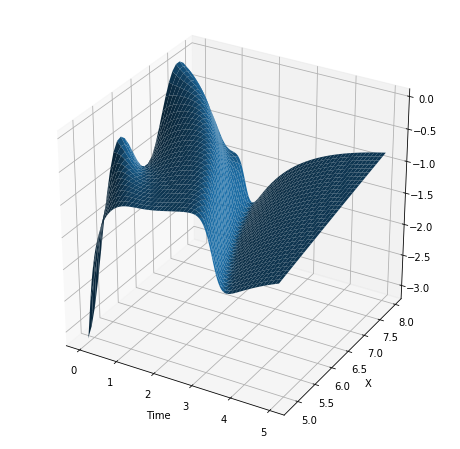

array([[-3.15254935, -3.00411055, -2.73868844, ..., -0.2623866 ,
        -0.41782701, -0.57065298],
       [-3.13156313, -2.96656869, -2.69181116, ..., -0.26504718,
        -0.42092886, -0.5740619 ],
       [-3.10809843, -2.92800344, -2.64550379, ..., -0.26774056,
        -0.42405581, -0.57748634],
       ...,
       [-1.37212855, -1.3536924 , -1.33528526, ..., -0.85687566,
        -0.84000309, -0.82318548],
       [-1.37086535, -1.35244821, -1.33406018, ..., -0.85615508,
        -0.83929898, -0.82249754],
       [-1.36960462, -1.35120645, -1.3328375 , ..., -0.8554358 ,
        -0.83859612, -0.82181082]])

In [38]:
data_model_burgers.visualize(1,subset=True)